<a href="https://colab.research.google.com/github/banned-from-uni/SWELL-DL/blob/main/SWELL-1D-CNN-LIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#!pip install lime

In [4]:
from lime.lime_tabular import RecurrentTabularExplainer

## Part 1: Gather & Store Data

In [5]:
train = pd.read_csv('/content/drive/My Drive/SWELL/train.csv').drop('datasetId',axis=1)
test = pd.read_csv('/content/drive/My Drive/SWELL/test.csv').drop('datasetId',axis=1)

## Part 2: Clean & Organize Data

In [6]:
swell = pd.concat([train,test], axis=0)
swell = swell.reset_index(drop=True)

## Part 4: Machine Learning

### Feature Selection

In [7]:
X = swell.drop('condition',axis=1).to_numpy()
y = swell['condition']

In [8]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
print(y.unique())
y = encoder.fit_transform(y)
print(np.unique(y))

['no stress' 'interruption' 'time pressure']
[0 1 2]


In [9]:
print(type(X))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [10]:
print(X.shape)
print(y.shape)

(410322, 34)
(410322,)


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.20, random_state=101)

In [12]:
from sklearn.feature_selection import SelectKBest, f_classif
best_features = SelectKBest(score_func=f_classif)
best_features.fit_transform(X_train, y_train)

array([[ 973.06157957,  846.926255  ,   14.58269343, ..., 3654.56133348,
          81.32772655,  816.82074339],
       [ 921.1755808 ,  861.101565  ,   14.15899927, ..., 1429.71088907,
          62.90027791,  834.50497605],
       [ 812.77586422,  812.742645  ,   14.36159637, ...,  486.3619201 ,
          43.99496077,  563.27301469],
       ...,
       [ 800.61430917,  804.241965  ,   12.27222442, ..., 1695.71786535,
          72.5014297 ,  622.8735223 ],
       [ 807.25413643,  809.24277   ,   19.18883663, ..., 1133.85748765,
          43.51562567, 1419.30698835],
       [ 851.97274913,  858.354115  ,   11.02482941, ...,  920.77325673,
          61.11719693,  573.84606358]])

In [13]:
anova = pd.Series(data=best_features.scores_,index=swell.columns[:-1])
anova = anova.sort_values(ascending=False)

In [14]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

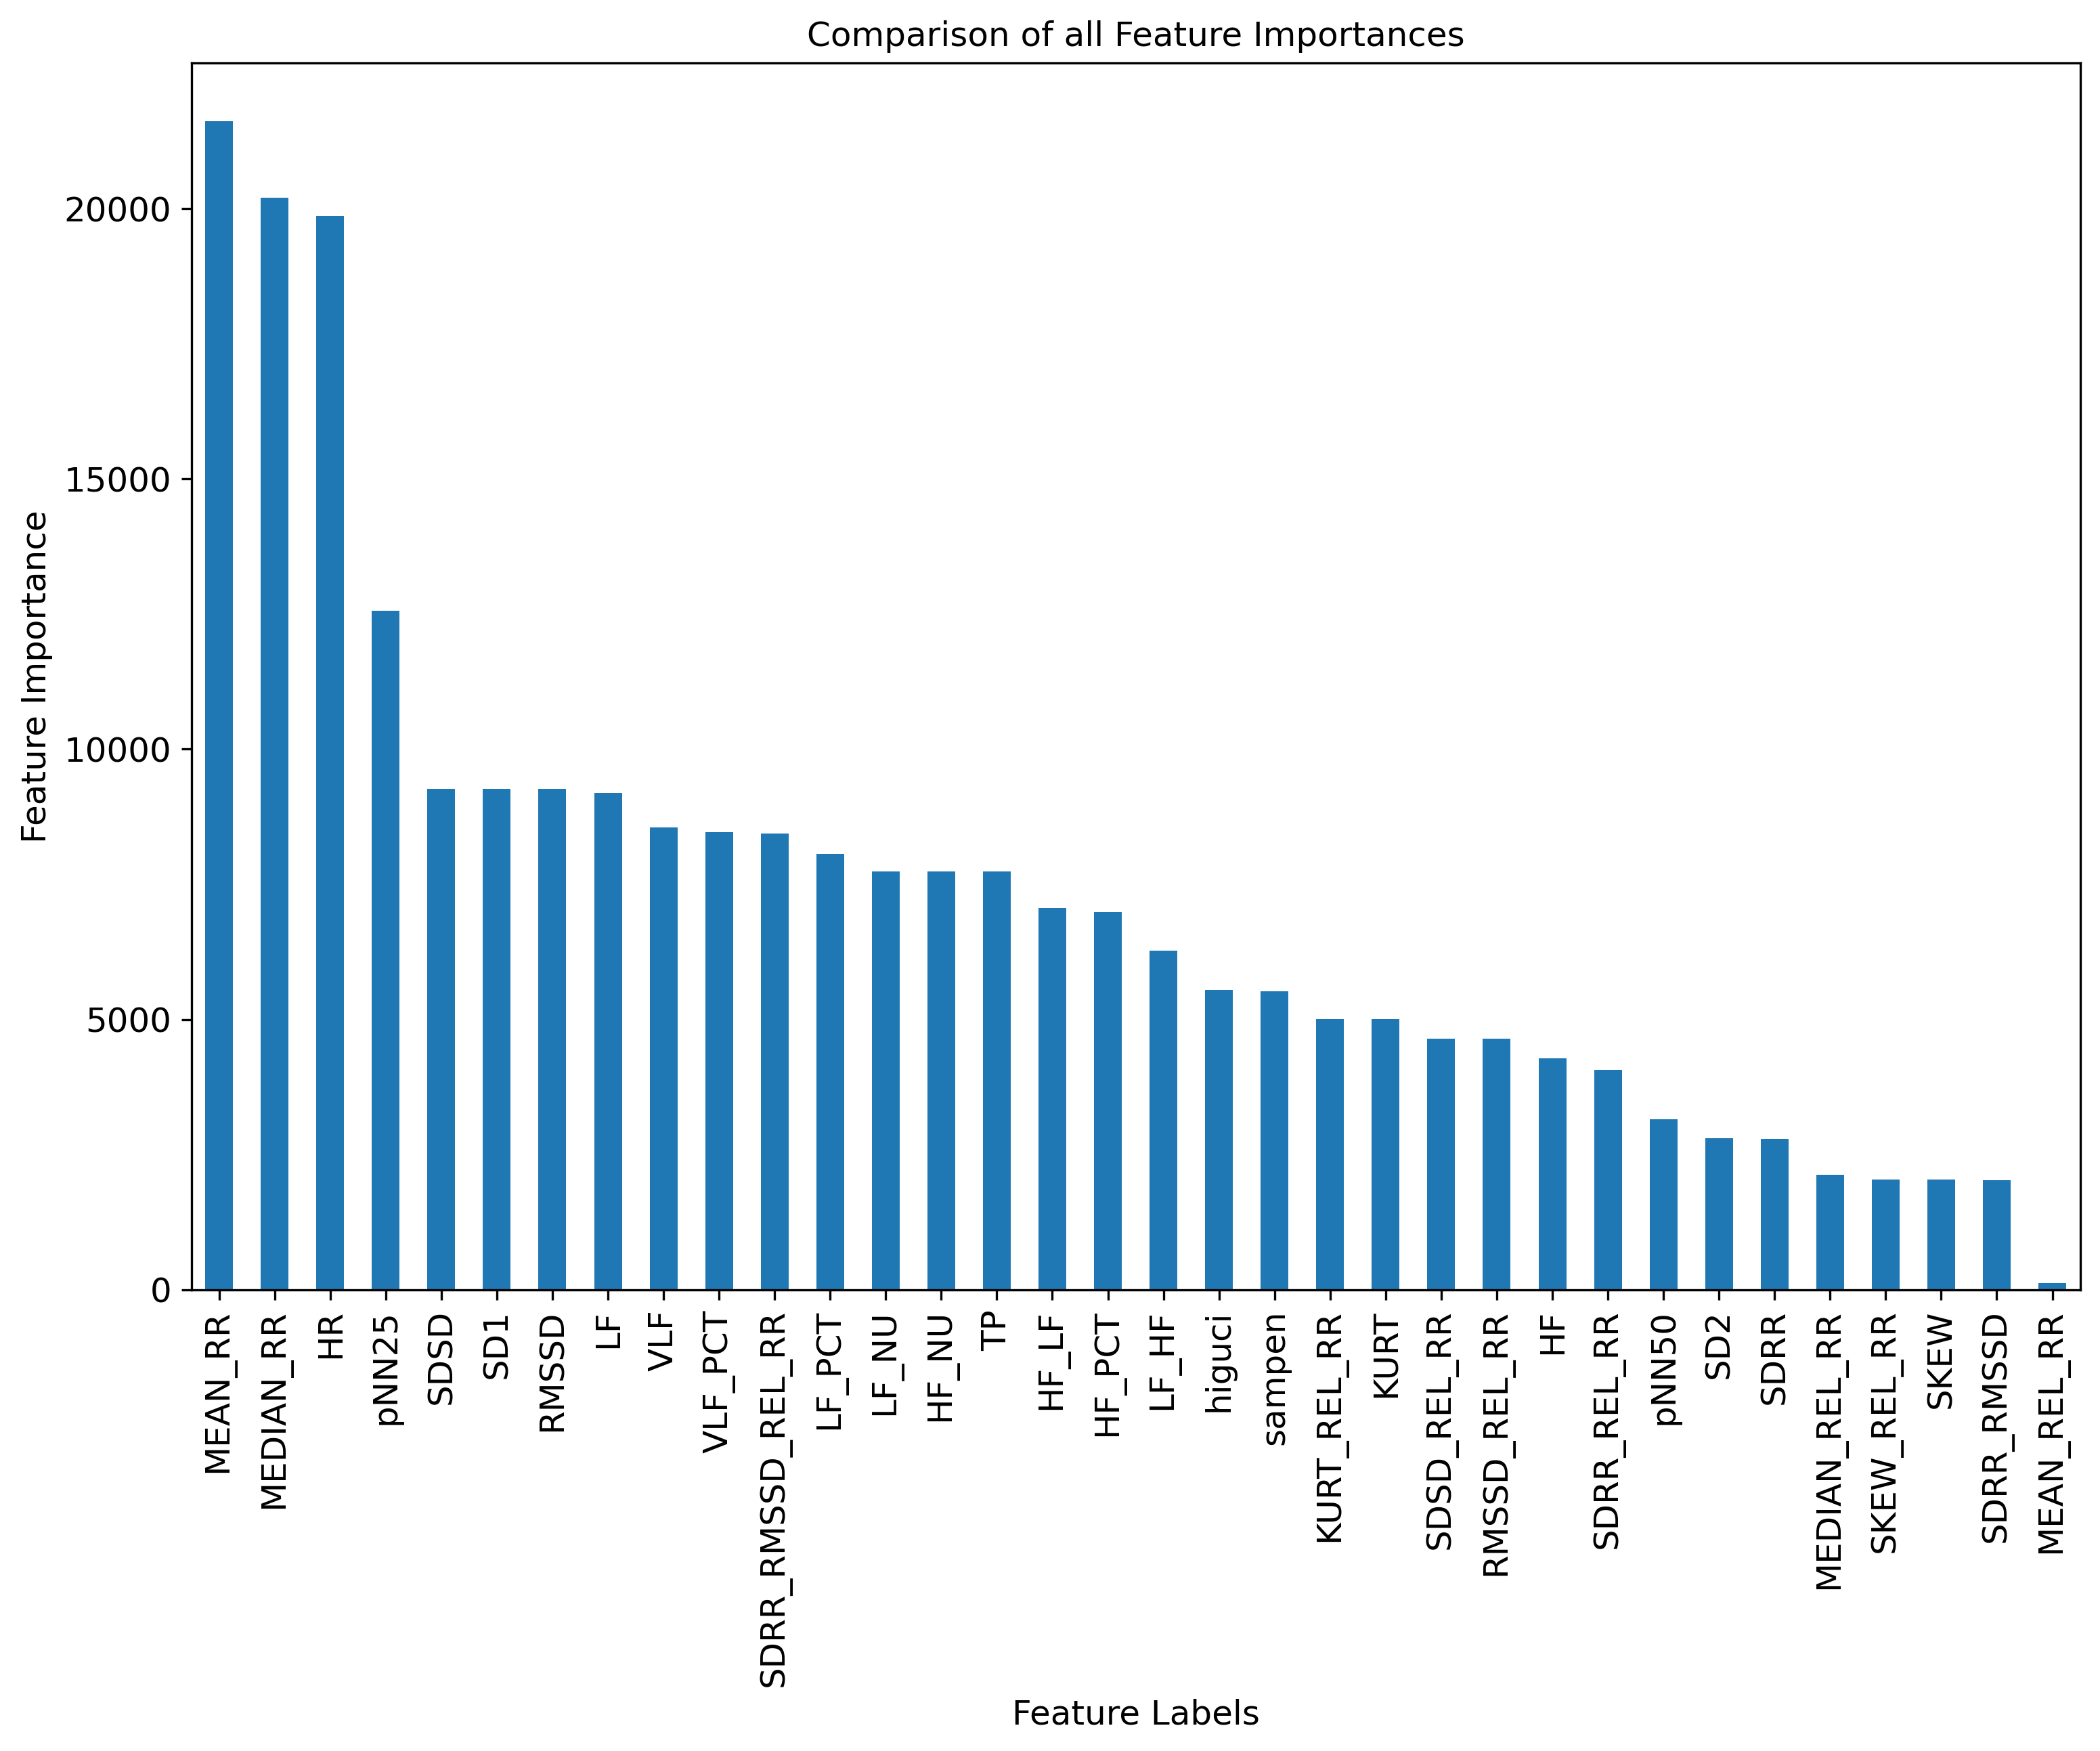

In [15]:
plt.figure(figsize=(12, 8),dpi=300)
plt.xlabel("Feature Labels")
plt.ylabel("Feature Importance")
plt.title("Comparison of all Feature Importances")
anova.plot.bar();

### 1D CNN

In [16]:
feature_names = anova.index[:-1]

In [17]:
X = swell[feature_names].to_numpy()
y = swell['condition']

In [18]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.20, random_state=101)

In [19]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
print(y_train.unique())
train_class_names = y_train.unique()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)
print(np.unique(y_train))

['no stress' 'interruption' 'time pressure']
[0 1 2]


In [20]:
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
print(X_train.shape)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_train.shape)

(328257, 33)
(328257, 1, 33)


In [23]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

def create_model():
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, activation="relu", padding="same"))
  model.add(Dense(16, activation="relu"))
  model.add(MaxPooling1D(padding='same'))
  model.add(Flatten())
  model.add(Dense(3, activation = 'softmax'))

  model.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = "adam",
                metrics = ['accuracy'])

  return model

In [25]:
with tf.device('/CPU:0'):
  model = create_model()
  history = model.fit(X_train, y_train, batch_size=64,
            epochs=600, verbose = 1,
            validation_data=(X_test, y_test),
            callbacks = [early_stop])

Epoch 1/600
5130/5130 [==============================] - 34s 6ms/step - loss: 0.6451 - accuracy: 0.7227 - val_loss: 0.4708 - val_accuracy: 0.8068
Epoch 2/600
5130/5130 [==============================] - 17s 3ms/step - loss: 0.3836 - accuracy: 0.8493 - val_loss: 0.3478 - val_accuracy: 0.8490
Epoch 3/600
5130/5130 [==============================] - 14s 3ms/step - loss: 0.2657 - accuracy: 0.9010 - val_loss: 0.2225 - val_accuracy: 0.9185
Epoch 4/600
5130/5130 [==============================] - 15s 3ms/step - loss: 0.1994 - accuracy: 0.9288 - val_loss: 0.1641 - val_accuracy: 0.9459
Epoch 5/600
5130/5130 [==============================] - 15s 3ms/step - loss: 0.1540 - accuracy: 0.9471 - val_loss: 0.1436 - val_accuracy: 0.9516
Epoch 6/600
5130/5130 [==============================] - 17s 3ms/step - loss: 0.1222 - accuracy: 0.9586 - val_loss: 0.1058 - val_accuracy: 0.9646
Epoch 7/600
5130/5130 [==============================] - 15s 3ms/step - loss: 0.0997 - accuracy: 0.9670 - val_loss: 0.1819 -

In [26]:
loss, accuracy = model.evaluate(X_train, y_train)
print("Loss:", loss, " Accuracy:", accuracy)

10259/10259 [==============================] - 15s 1ms/step - loss: 0.0043 - accuracy: 0.9988
Loss: 0.004297688137739897  Accuracy: 0.9987723231315613


In [27]:
pred = model.predict(X_test)
pred_y = pred.argmax(axis=-1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_y)

[[23240     9     0]
 [    1 44493     1]
 [    4    91 14226]]


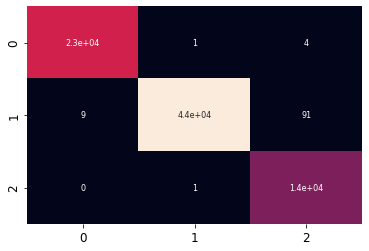

In [28]:
print(cm)
sns.heatmap(cm.T, annot=True, cbar = False);

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23249
           1       1.00      1.00      1.00     44495
           2       1.00      0.99      1.00     14321

    accuracy                           1.00     82065
   macro avg       1.00      1.00      1.00     82065
weighted avg       1.00      1.00      1.00     82065



In [30]:
pred = model.predict(X_test[:30])
pred_y = pred.argmax(axis=-1)
print(f"Actual:    {pred_y}")
print(f"Predicted: {y_test[:30]}")

Actual:    [1 0 1 2 1 1 1 2 1 0 1 2 0 1 1 1 1 0 1 1 1 1 0 1 0 2 1 0 0 0]
Predicted: [1 0 1 2 1 1 1 2 1 0 1 2 0 1 1 1 1 0 1 1 1 1 0 1 0 2 1 0 0 0]


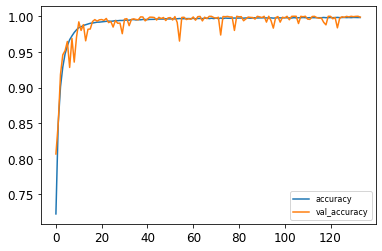

In [31]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy','val_accuracy']].plot();

### Explanation

In [32]:
explainer = RecurrentTabularExplainer(training_data=X_train,
                                      mode='classification',
                                      training_labels=y_train,
                                      feature_names=feature_names,
                                      class_names=train_class_names)

In [33]:
explanation = explainer.explain_instance(X_train[0],model.predict,num_features=len(feature_names))

In [34]:
explanation.as_list()

[('MEAN_RR_t-0 > 0.49', -0.1138344737444904),
 ('0.03 < HF_t-0 <= 0.07', 0.10609887616731183),
 ('0.30 < SDRR_REL_RR_t-0 <= 0.47', -0.07257728503525275),
 ('sampen_t-0 <= 0.89', 0.07040856207526375),
 ('VLF_t-0 > 0.20', -0.06527748407158386),
 ('VLF_PCT_t-0 > 0.73', 0.05887715182790315),
 ('0.03 < HF_LF_t-0 <= 0.08', -0.05699356073262793),
 ('RMSSD_REL_RR_t-0 > 0.35', -0.050154059614247196),
 ('0.54 < MEDIAN_REL_RR_t-0 <= 0.63', 0.04617024367371167),
 ('SDRR_t-0 > 0.17', -0.0459220436593011),
 ('0.23 < SDRR_RMSSD_REL_RR_t-0 <= 0.30', -0.04011432008800413),
 ('0.04 < HF_NU_t-0 <= 0.11', -0.038492442836719536),
 ('SD2_t-0 > 0.17', -0.03811674924944646),
 ('0.42 < RMSSD_t-0 <= 0.59', 0.03408370975380392),
 ('LF_PCT_t-0 <= 0.27', 0.03358662421730126),
 ('0.28 < HR_t-0 <= 0.39', -0.03244821473889979),
 ('0.22 < LF_t-0 <= 0.35', 0.029240236452146687),
 ('SKEW_t-0 > 0.27', -0.028431509226361965),
 ('SDRR_RMSSD_t-0 > 0.10', 0.026891306166619826),
 ('SDSD_REL_RR_t-0 > 0.35', -0.0236746169203870

In [36]:
model.save("/content/drive/My Drive/SWELL/model_998")

INFO:tensorflow:Assets written to: /content/drive/My Drive/SWELL/model_998/assets
